In [1]:
import matplotlib.pyplot as plt

import numpy as np

import json
import glob
import sys
import os

sys.path.append('../src')

### Visualization of training loss and test accuracy

In [2]:
with open('../experiments/history/history-AConvNet-SOC.json') as f:
    history = json.load(f)

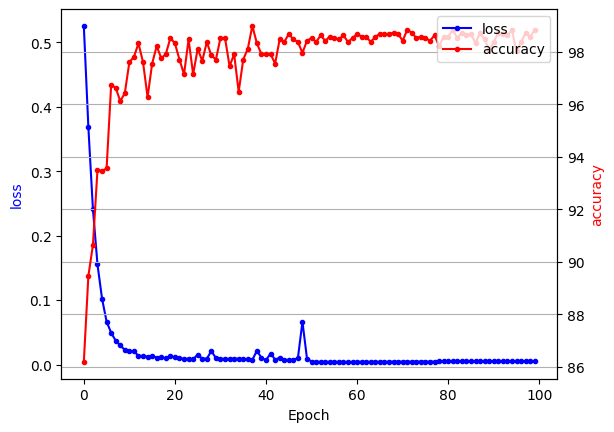

In [3]:
training_loss = history['loss']
test_accuracy = history['accuracy']

epochs = np.arange(len(training_loss))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plot1, = ax1.plot(epochs, training_loss, marker='.', c='blue', label='loss')
plot2, = ax2.plot(epochs, test_accuracy, marker='.', c='red', label='accuracy')
plt.legend([plot1, plot2], ['loss', 'accuracy'], loc='upper right')

plt.grid()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss', color='blue')
ax2.set_ylabel('accuracy', color='red')
plt.show()


### Early Stopping

In [4]:
from tqdm import tqdm
import torchvision
import torch

from utils import common
from data import preprocess
from data import loader_azimuth as loader
import model

In [5]:
def load_dataset(path, is_train, name, batch_size):

    _dataset = loader.Dataset(
        path, name=name, is_train=is_train,
        transform=torchvision.transforms.Compose([
            preprocess.CenterCrop(88), torchvision.transforms.ToTensor()
        ])
    )
    data_loader = torch.utils.data.DataLoader(
        _dataset, batch_size=batch_size, shuffle=is_train, num_workers=1
    )
    return data_loader


# def evaluate(_m, ds):
    
#     num_data = 0
#     corrects = 0
    
#     _m.net.eval()
#     _softmax = torch.nn.Softmax(dim=1)
#     for i, data in enumerate(ds):
#         images, labels, _, azimuth_angles = data

#         predictions = _m.inference(images)
#         predictions = _softmax(predictions)

#         _, predictions = torch.max(predictions.data, 1)
#         labels = labels.type(torch.LongTensor)
#         num_data += labels.size(0)
#         corrects += (predictions == labels.to(m.device)).sum().item()

#     accuracy = 100 * corrects / num_data
#     return accuracy

def evaluate(_m, ds):
    num_data = 0
    corrects = 0
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)

    # Lists to store azimuth angles and correctness (True for correct, False for incorrect)
    azimuth_angles = []
    correctness = []

    for i, data in enumerate(ds):
        images, labels, _, azimuth = data

        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        
        num_data += labels.size(0)
        corrects += (predictions == labels.to(m.device)).sum().item()

        # Store azimuth angle and whether the prediction was correct or not
        for idx in range(len(labels)):
            azimuth_angles.append(azimuth[idx].item())  # azimuth angle for each sample
            correctness.append((predictions[idx] == labels[idx].to(m.device)).item())

    accuracy = 100 * corrects / num_data
    return accuracy, azimuth_angles, correctness

In [6]:

config = common.load_config(os.path.join(common.project_root, 'experiments/config/AConvNet-SOC.json'))
model_name = config['model_name']
test_set = load_dataset('dataset', False, 'soc', 100)

m = model.Model(
    classes=config['num_classes'], channels=config['channels'],
)

model_history = glob.glob(os.path.join(common.project_root, f'experiments/model/{model_name}/*.pth'))
model_history = sorted(model_history, key=os.path.basename)

best = {
    'epoch': 0,
    'accuracy': 0,
    'path': ''
}

for i, model_path in enumerate(model_history):
    m.load(model_path)
    accuracy, azimuth_angles, correctness = evaluate(m, test_set)
    if accuracy > best['accuracy']:
        best['epoch'] = i
        best['accuracy'] = accuracy
        best['path'] = model_path
        best['azimuth_angles'] = azimuth_angles
        best['correctness'] = correctness
        print(f'Best accuracy at epoch={i} with {accuracy:.2f}%')
    
best_epoch = best['epoch']
best_accuracy = best['accuracy']
best_path = best['path']

print(f'Final model is epoch={best_epoch} with accurayc={best_accuracy:.2f}%')
print(f'Path={best_path}')

load test data set: 2425it [00:24, 100.89it/s]
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Best accuracy at epoch=0 with 69.61%
Best accuracy at epoch=1 with 82.93%
Best accuracy at epoch=3 with 88.66%
Best accuracy at epoch=4 with 89.81%
Best accuracy at epoch=10 with 89.86%
Best accuracy at epoch=12 with 90.35%
Best accuracy at epoch=15 with 90.47%
Best accuracy at epoch=16 with 90.76%
Best accuracy at epoch=22 with 91.18%
Best accuracy at epoch=26 with 91.22%
Best accuracy at epoch=29 with 91.46%
Best accuracy at epoch=58 with 91.92%
Best accuracy at epoch=63 with 92.00%
Best accuracy at epoch=78 with 92.25%
Best accuracy at epoch=89 with 92.41%
Final model is epoch=89 with accurayc=92.41%
Path=/workspace/experiments/model/AConvNet-SOC/model-090.pth


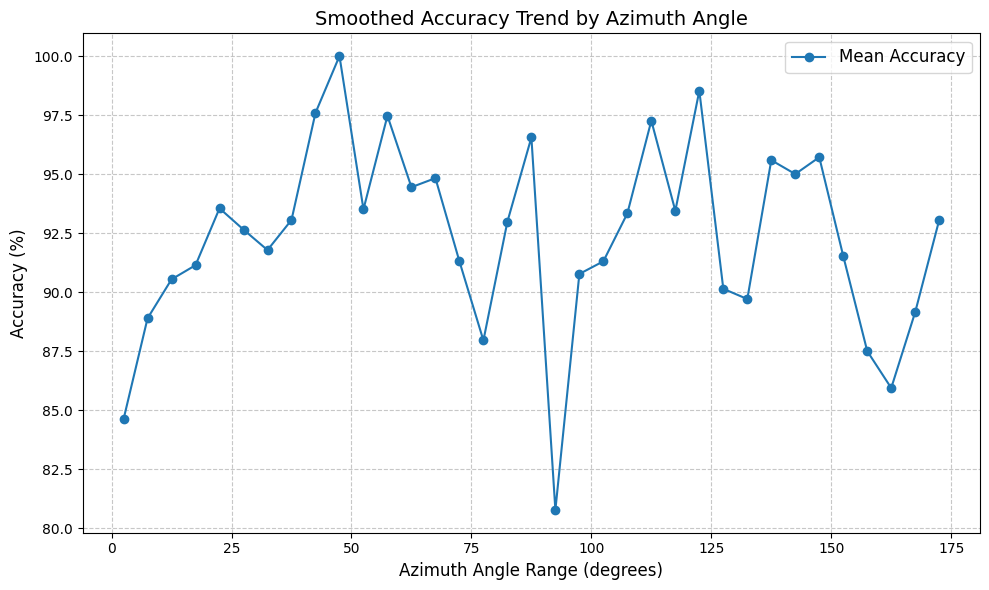

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve azimuth_angles and correctness from best
azimuth_angles_tensor = best['azimuth_angles']
correctness_tensor = best['correctness']

# Check if azimuth_angles and correctness are tensors (GPU or not)
if isinstance(azimuth_angles_tensor, torch.Tensor):  # Check if it's a tensor
    azimuth_angles = azimuth_angles_tensor.cpu().numpy()  # Move to CPU and convert to NumPy
else:
    azimuth_angles = np.array(azimuth_angles_tensor)  # If it's already a list, convert to NumPy array

if isinstance(correctness_tensor, torch.Tensor):  # Check if it's a tensor
    correctness = correctness_tensor.cpu().numpy()  # Move to CPU and convert to NumPy
else:
    correctness = np.array(correctness_tensor)  # If it's already a list, convert to NumPy array

import numpy as np
import matplotlib.pyplot as plt

# Assuming azimuth_angles and correctness are NumPy arrays
# Group azimuth angles into bins
bins = np.arange(0, 180, 5)  # Bin edges (e.g., intervals of 30 degrees)
digitized = np.digitize(azimuth_angles, bins)  # Assign each azimuth to a bin

# Calculate bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate accuracy for each bin
accuracy_per_bin = []
for bin_id in range(1, len(bins)):
    bin_correct = [correctness[i] for i in range(len(correctness)) if digitized[i] == bin_id]
    if len(bin_correct) > 0:
        accuracy_per_bin.append(np.mean(bin_correct) * 100)  # Mean accuracy for the bin
    else:
        accuracy_per_bin.append(None)  # Leave gaps for empty bins

# Plot the smoothed accuracy trend
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, accuracy_per_bin, marker='o', linestyle='-', label='Mean Accuracy')

# Add labels and grid for better readability
plt.title("Smoothed Accuracy Trend by Azimuth Angle", fontsize=14)
plt.xlabel("Azimuth Angle Range (degrees)", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

